# **Mô hình KNN**

## **Import các thư viện cần thiết**

In [852]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from fractions import Fraction

## **Dữ liệu**

In [853]:
df = pd.read_csv("../data/data_processed/data_processed.csv")
df.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,4.0,0.0,4.0,2.0,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,2.0,0.0,5.0,2.0,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,2.0,0.0,6.0,2.0,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,4.0,0.0,5.0,0.0,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


## **Xây dựng mô hình KNN**

In [854]:
# Các đặc trưng và nhãn
X = df.drop(columns=['NSP']).values 
y = df['NSP'].values  

In [855]:
# Hàm tính khoảng cách Euclidean 
def distance(array, value):
    return np.linalg.norm(array - value, axis=1)

# Hàm tìm K hàng xóm gần nhất (trả về chỉ số)
def find_nearest_index(X_train, x_val, K):
    distances = distance(X_train, x_val)
    return np.argsort(distances)[:K]

# Trả về nhãn phổ biến nhất trong list
def highest_rank(arr):
    count_num = {}
    for i in arr:
        count_num[i] = arr.count(i)
    return max(count_num, key=count_num.get)

# Mô hình KNN 
def knn(X_train, y_train, X_test, K):
    y_pred = np.zeros(len(X_test), dtype=int)

    for j in range(len(X_test)):
        indexes = find_nearest_index(X_train, X_test[j], K)
        y_nearest = [y_train[i] for i in indexes]
        y_pred[j] = highest_rank(y_nearest)

    return y_pred

## **Triển khai KNN với nhiều tỷ lệ train/validation: 4:1; 7:3; 6:4**

### **Thực hiện với dữ liệu gốc**

In [856]:
test_sizes = [0.2, 0.3, 0.4]  
k_values = [3, 5, 7]  

results = []

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    
    for k in k_values:
        y_pred = knn(X_train, y_train, X_test, k)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
        results.append({
            'Tỷ lệ Train/Test': f"{1-test_size:.1f}:{test_size:.1f}",
            'k': k,
            'Accuracy': acc,
            'F1-Score': f1
        })

# Chuyển kết quả thành DataFrame
results_df = pd.DataFrame(results)
print("Dữ liệu gốc:")
print(results_df.pivot_table(index='k', columns='Tỷ lệ Train/Test', values=['Accuracy', 'F1-Score']))

Dữ liệu gốc:
                  Accuracy                      F1-Score                    
Tỷ lệ Train/Test   0.6:0.4   0.7:0.3   0.8:0.2   0.6:0.4   0.7:0.3   0.8:0.2
k                                                                           
3                 0.898942  0.904389  0.903756  0.803442  0.813737  0.802382
5                 0.893067  0.899687  0.903756  0.794868  0.804600  0.803953
7                 0.886016  0.882445  0.884977  0.780383  0.769176  0.761845


In [857]:
#k=3
ratios = {
    0.2: "4:1",
    0.3: "7:3",
    0.4: "6:4"
}


test_sizes = [0.2, 0.3, 0.4]  # Tương ứng 4:1, 7:3, 6:4

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )
    
    y_pred = knn(X_train, y_train, X_test, 3)

    print("Mô hình KNN (k=3) với dữ liệu gốc:")
    print(f"Tỷ lệ {ratios[test_size]}")
    cr = classification_report(y_test, y_pred, zero_division=0)
    print(f"{cr}\n")
  

Mô hình KNN (k=3) với dữ liệu gốc:
Tỷ lệ 4:1
              precision    recall  f1-score   support

         1.0       0.93      0.98      0.95       332
         2.0       0.73      0.59      0.65        59
         3.0       0.87      0.74      0.80        35

    accuracy                           0.90       426
   macro avg       0.84      0.77      0.80       426
weighted avg       0.90      0.90      0.90       426


Mô hình KNN (k=3) với dữ liệu gốc:
Tỷ lệ 7:3
              precision    recall  f1-score   support

         1.0       0.94      0.97      0.95       497
         2.0       0.72      0.65      0.68        88
         3.0       0.87      0.75      0.81        53

    accuracy                           0.90       638
   macro avg       0.84      0.79      0.81       638
weighted avg       0.90      0.90      0.90       638


Mô hình KNN (k=3) với dữ liệu gốc:
Tỷ lệ 6:4
              precision    recall  f1-score   support

         1.0       0.93      0.97      0.95   

In [885]:
#k=3
ratios = {
    0.3: "7:3",
}


test_sizes = [0.3]  

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )
    
    y_pred = knn(X_train, y_train, X_test, 3)

    print("Mô hình KNN (k=3) với dữ liệu gốc:")
    print(f"Tỷ lệ {ratios[test_size]}")
    cr = classification_report(y_test, y_pred, zero_division=0)
    print(f"{cr}\n")
  

Mô hình KNN (k=3) với dữ liệu gốc:
Tỷ lệ 7:3
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95       497
         1.0       0.72      0.65      0.68        88
         2.0       0.87      0.75      0.81        53

    accuracy                           0.90       638
   macro avg       0.84      0.79      0.81       638
weighted avg       0.90      0.90      0.90       638




In [858]:
# Tìm ra mô hình tốt nhất (có độ chính xác cao nhất)
best_model = results_df.loc[results_df['F1-Score'].idxmax()]

# Thông tin mô hình tốt nhất
best_k = best_model['k']
best_test_size = best_model['Tỷ lệ Train/Test']
print(f'Mô hình tốt nhất (dữ liệu gốc): k={best_k}, Tỷ lệ Train/Test={best_test_size}')
print(f"\nAccuracy (dữ liệu gốc): = {best_model["F1-Score"]}")


Mô hình tốt nhất (dữ liệu gốc): k=3, Tỷ lệ Train/Test=0.7:0.3

Accuracy (dữ liệu gốc): = 0.813736862708227


In [859]:
# Tìm ra mô hình tốt nhất (có độ chính xác cao nhất)
best_model = results_df.loc[results_df['Accuracy'].idxmax()]

# Thông tin mô hình tốt nhất
best_k = best_model['k']
best_test_size = best_model['Tỷ lệ Train/Test']
print(f'Mô hình tốt nhất (dữ liệu gốc): k={best_k}, Tỷ lệ Train/Test={best_test_size}')
print(f"\nAccuracy (dữ liệu gốc): = {best_model["Accuracy"]}")

# Tìm lại dữ liệu tập huấn luyện và kiểm tra cho mô hình tốt nhất
test_size_dict = {'0.6:0.4': 0.4, '0.7:0.3': 0.3, '0.8:0.2': 0.2}
test_size = test_size_dict[best_test_size]

X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(X, y, test_size=test_size, random_state=42)

# Huấn luyện và dự đoán với k tốt nhất
y_pred_best = knn(X_train_best, y_train_best, X_test_best, best_k)

print("\nClassification Report (dữ liệu gốc):")
print(classification_report(y_test_best, y_pred_best))

Mô hình tốt nhất (dữ liệu gốc): k=3, Tỷ lệ Train/Test=0.7:0.3

Accuracy (dữ liệu gốc): = 0.9043887147335423

Classification Report (dữ liệu gốc):
              precision    recall  f1-score   support

         1.0       0.93      0.95      0.94       496
         2.0       0.72      0.62      0.67       101
         3.0       0.78      0.78      0.78        41

    accuracy                           0.89       638
   macro avg       0.81      0.79      0.80       638
weighted avg       0.88      0.89      0.89       638



In [860]:
print("Confusion matrix:")
print(confusion_matrix(y_test_best, y_pred_best))

Confusion matrix:
[[472  20   4]
 [ 33  63   5]
 [  5   4  32]]


### **Giảm trước chia sau** (Tiềm ẩn Data leakage)

In [861]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X = scaler.fit_transform(X)

#### **Thực hiện với dữ liệu đã giảm chiều bằng PCA**

In [862]:
pca = PCA(n_components=12)
X_pca = pca.fit_transform(X)

test_sizes = [0.2, 0.3, 0.4]  
k_values = [3, 5, 7]  

results_pca = []

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=test_size, stratify=y, random_state=42)
    
    for k in k_values:
        y_pred = knn(X_train, y_train, X_test, k)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
        results_pca.append({
            'Tỷ lệ Train/Test': f"{1-test_size:.1f}:{test_size:.1f}",
            'k': k,
            'Accuracy': acc,
            'F1-Score': f1
        })
        
# Chuyển kết quả thành DataFrame
results_df_pca = pd.DataFrame(results_pca)
print(results_df_pca.pivot(index='k', columns='Tỷ lệ Train/Test', values=['Accuracy', 'F1-Score']))

                  Accuracy                      F1-Score                    
Tỷ lệ Train/Test   0.6:0.4   0.7:0.3   0.8:0.2   0.6:0.4   0.7:0.3   0.8:0.2
k                                                                           
3                 0.896592  0.894984  0.884977  0.790524  0.788278  0.768491
5                 0.884841  0.877743  0.880282  0.761767  0.743628  0.745807
7                 0.889542  0.884013  0.877934  0.771769  0.762333  0.750000


In [863]:
ratios = {
    0.2: "4:1",
    0.3: "7:3",
    0.4: "6:4"
}

test_sizes = [0.2, 0.3, 0.4]  # Tương ứng 4:1, 7:3, 6:4

for test_size in test_sizes:
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, stratify=y, test_size=test_size, random_state=42)
    y_pred_pca = knn(X_train_pca, y_train_pca, X_test_pca, 3)
    
    print("Mô hình KNN (k=3) với dữ liệu PCA:")
    print(f"Tỷ lệ {ratios[test_size]}")
    print(classification_report(y_test_pca, y_pred_pca, zero_division=0))
    print() 


Mô hình KNN (k=3) với dữ liệu PCA:
Tỷ lệ 4:1
              precision    recall  f1-score   support

         1.0       0.92      0.96      0.94       332
         2.0       0.66      0.56      0.61        59
         3.0       0.81      0.71      0.76        35

    accuracy                           0.88       426
   macro avg       0.80      0.74      0.77       426
weighted avg       0.88      0.88      0.88       426


Mô hình KNN (k=3) với dữ liệu PCA:
Tỷ lệ 7:3
              precision    recall  f1-score   support

         1.0       0.93      0.97      0.95       497
         2.0       0.68      0.61      0.64        88
         3.0       0.90      0.68      0.77        53

    accuracy                           0.89       638
   macro avg       0.83      0.75      0.79       638
weighted avg       0.89      0.89      0.89       638


Mô hình KNN (k=3) với dữ liệu PCA:
Tỷ lệ 6:4
              precision    recall  f1-score   support

         1.0       0.93      0.97      0.95   

In [864]:
# Tìm ra mô hình tốt nhất 
best_model = results_df_pca.loc[results_df_pca['Accuracy'].idxmax()]

# Thông tin mô hình tốt nhất
best_k = best_model['k']
best_test_size = best_model['Tỷ lệ Train/Test']
print(f'Mô hình tốt nhất (dữ liệu giảm chiều bằng PCA): k={best_k}, Tỷ lệ Train/Test={best_test_size}')
print(f"\nAccuracy (dữ liệu giảm chiều bằng PCA): = {best_model["Accuracy"]}")

# Tìm lại dữ liệu tập huấn luyện và kiểm tra cho mô hình tốt nhất
test_size_dict = {'0.6:0.4': 0.4, '0.7:0.3': 0.3, '0.8:0.2': 0.2}
test_size = test_size_dict[best_test_size]

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=test_size, stratify=y, random_state=42)

# Huấn luyện và dự đoán với k tốt nhất
y_pred_pca = knn(X_train_pca, y_train_pca, X_test_pca, best_k)

print("\nClassification Report (PCA):")
print(classification_report(y_test_pca, y_pred_pca))

Mô hình tốt nhất (dữ liệu giảm chiều bằng PCA): k=3, Tỷ lệ Train/Test=0.6:0.4

Accuracy (dữ liệu giảm chiều bằng PCA): = 0.8965922444183314

Classification Report (PCA):
              precision    recall  f1-score   support

         1.0       0.93      0.97      0.95       663
         2.0       0.70      0.57      0.63       118
         3.0       0.88      0.73      0.80        70

    accuracy                           0.90       851
   macro avg       0.83      0.76      0.79       851
weighted avg       0.89      0.90      0.89       851



In [865]:
print("Confusion matrix (PCA):")
print(confusion_matrix(y_test_pca, y_pred_pca))

Confusion matrix (PCA):
[[645  17   1]
 [ 45  67   6]
 [  7  12  51]]


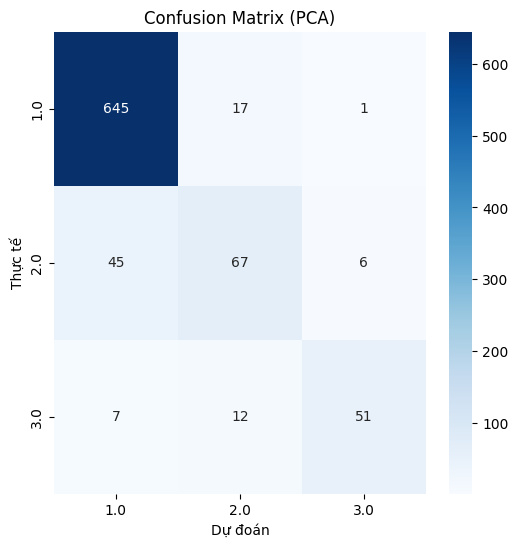

In [866]:
conf_matrix_pca = confusion_matrix(y_test_pca, y_pred_pca)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_pca, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (PCA)")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

#### **Thực hiện với dữ liệu đã giảm chiều bằng LDA**

In [867]:
lda = LDA(n_components=2)  
X_lda = lda.fit_transform(X, y)

test_sizes = [0.2, 0.3, 0.4]  
k_values = [3, 5, 7]  

results_lda = []

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=test_size, stratify=y, random_state=42)
    
    for k in k_values:
        y_pred = knn(X_train, y_train, X_test, k)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
        results_lda.append({
            'Tỷ lệ Train/Test': f"{1-test_size:.1f}:{test_size:.1f}",
            'k': k,
            'Accuracy': acc,
            'F1-Score': f1
        })
        
# Chuyển kết quả thành DataFrame
results_df_lda = pd.DataFrame(results_pca)
print(results_df_lda.pivot(index='k', columns='Tỷ lệ Train/Test', values=['Accuracy', 'F1-Score']))



                  Accuracy                      F1-Score                    
Tỷ lệ Train/Test   0.6:0.4   0.7:0.3   0.8:0.2   0.6:0.4   0.7:0.3   0.8:0.2
k                                                                           
3                 0.896592  0.894984  0.884977  0.790524  0.788278  0.768491
5                 0.884841  0.877743  0.880282  0.761767  0.743628  0.745807
7                 0.889542  0.884013  0.877934  0.771769  0.762333  0.750000


In [868]:
ratios = {
    0.2: "4:1",
    0.3: "7:3",
    0.4: "6:4"
}

test_sizes = [0.2, 0.3, 0.4]  # Tương ứng 4:1, 7:3, 6:4

for test_size in test_sizes:
    X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(X_lda, y, test_size=test_size, stratify=y,random_state=42)
    y_pred_lda = knn(X_train_lda, y_train_lda, X_test_lda, best_k)

    print("Mô hình KNN (k=3) với dữ liệu LDA:")
    print(f"Tỷ lệ {ratios[test_size]}")
    print(classification_report(y_test_lda, y_pred_lda, zero_division=0))
    print() 


Mô hình KNN (k=3) với dữ liệu LDA:
Tỷ lệ 4:1
              precision    recall  f1-score   support

         1.0       0.94      0.96      0.95       332
         2.0       0.66      0.63      0.64        59
         3.0       0.81      0.71      0.76        35

    accuracy                           0.89       426
   macro avg       0.80      0.77      0.78       426
weighted avg       0.89      0.89      0.89       426


Mô hình KNN (k=3) với dữ liệu LDA:
Tỷ lệ 7:3
              precision    recall  f1-score   support

         1.0       0.94      0.94      0.94       497
         2.0       0.63      0.69      0.66        88
         3.0       0.86      0.72      0.78        53

    accuracy                           0.89       638
   macro avg       0.81      0.78      0.79       638
weighted avg       0.89      0.89      0.89       638


Mô hình KNN (k=3) với dữ liệu LDA:
Tỷ lệ 6:4
              precision    recall  f1-score   support

         1.0       0.94      0.94      0.94   

In [869]:
# Tìm ra mô hình tốt nhất (có độ chính xác cao nhất)
best_model = results_df_lda.loc[results_df_lda['Accuracy'].idxmax()]

# Thông tin mô hình tốt nhất
best_k = best_model['k']
best_test_size = best_model['Tỷ lệ Train/Test']
print(f'Mô hình tốt nhất (dữ liệu giảm chiều bằng LDA): k={best_k}, Tỷ lệ Train/Test={best_test_size}')
print(f"\nAccuracy (dữ liệu giảm chiều bằng LDA): = {best_model["Accuracy"]}")

# Tìm lại dữ liệu tập huấn luyện và kiểm tra cho mô hình tốt nhất
test_size_dict = {'0.6:0.4': 0.4, '0.7:0.3': 0.3, '0.8:0.2': 0.2}
test_size = test_size_dict[best_test_size]

X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(X_lda, y, test_size=test_size, random_state=42)

# Huấn luyện và dự đoán với k tốt nhất
y_pred_lda = knn(X_train_lda, y_train_lda, X_test_lda, best_k)

print("\nClassification Report (LDA):")
print(classification_report(y_test_lda, y_pred_lda))

Mô hình tốt nhất (dữ liệu giảm chiều bằng LDA): k=3, Tỷ lệ Train/Test=0.6:0.4

Accuracy (dữ liệu giảm chiều bằng LDA): = 0.8965922444183314

Classification Report (LDA):
              precision    recall  f1-score   support

         1.0       0.94      0.92      0.93       673
         2.0       0.62      0.66      0.64       120
         3.0       0.72      0.81      0.76        58

    accuracy                           0.88       851
   macro avg       0.76      0.80      0.78       851
weighted avg       0.88      0.88      0.88       851



In [870]:
print("Confusion matrix (LDA):")
print(confusion_matrix(y_test_lda, y_pred_lda))

Confusion matrix (LDA):
[[621  43   9]
 [ 32  79   9]
 [  5   6  47]]


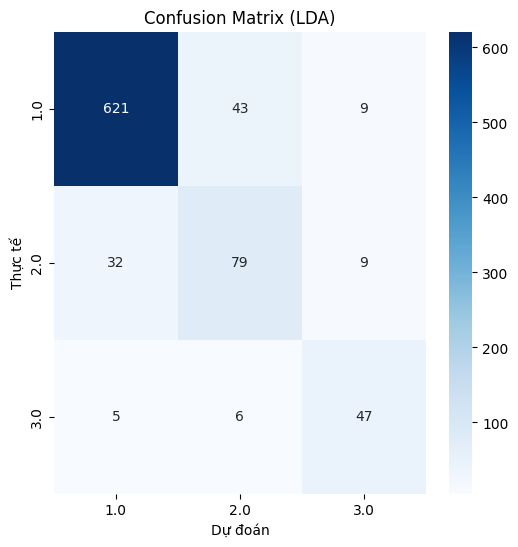

In [871]:
conf_matrix_lda = confusion_matrix(y_test_lda, y_pred_lda)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_lda, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (LDA)")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()


### **Chia trước giảm sau** 

#### **Thực hiện với dữ liệu đã giảm chiều bằng PCA**

In [872]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [873]:
test_sizes = [0.2, 0.3, 0.4]  
k_values = [3, 5, 7]  
n_components = 12
results_pca = []

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=42)

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)  

    for k in k_values:
        y_pred = knn(X_train_pca, y_train, X_test_pca, k)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
        results_pca.append({
            'Tỷ lệ Train/Test': f"{1-test_size:.1f}:{test_size:.1f}",
            'k': k,
            'Accuracy': acc,
            'F1-Score': f1
        })
        
# Chuyển kết quả thành DataFrame
results_df_pca = pd.DataFrame(results_pca)
print(results_df_pca.pivot(index='k', columns='Tỷ lệ Train/Test', values=['Accuracy', 'F1-Score']))

                  Accuracy                      F1-Score                    
Tỷ lệ Train/Test   0.6:0.4   0.7:0.3   0.8:0.2   0.6:0.4   0.7:0.3   0.8:0.2
k                                                                           
3                 0.894242  0.894984  0.882629  0.788805  0.789155  0.766135
5                 0.887192  0.879310  0.882629  0.766098  0.745166  0.754169
7                 0.888367  0.880878  0.880282  0.772907  0.754998  0.752338


In [874]:
ratios = {
    0.2: "4:1",
    0.3: "7:3",
    0.4: "6:4"
}

test_sizes = [0.2, 0.3, 0.4]  # Tương ứng 4:1, 7:3, 6:4

for test_size in test_sizes:
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, stratify=y, test_size=test_size, random_state=42)
    y_pred_pca = knn(X_train_pca, y_train_pca, X_test_pca, 3)
    
    print("Mô hình KNN (k=3) với dữ liệu PCA:")
    print(f"Tỷ lệ {ratios[test_size]}")
    print(classification_report(y_test_pca, y_pred_pca, zero_division=0))
    print() 


Mô hình KNN (k=3) với dữ liệu PCA:
Tỷ lệ 4:1
              precision    recall  f1-score   support

         1.0       0.92      0.96      0.94       332
         2.0       0.66      0.56      0.61        59
         3.0       0.81      0.71      0.76        35

    accuracy                           0.88       426
   macro avg       0.80      0.74      0.77       426
weighted avg       0.88      0.88      0.88       426


Mô hình KNN (k=3) với dữ liệu PCA:
Tỷ lệ 7:3
              precision    recall  f1-score   support

         1.0       0.93      0.97      0.95       497
         2.0       0.68      0.61      0.64        88
         3.0       0.90      0.68      0.77        53

    accuracy                           0.89       638
   macro avg       0.83      0.75      0.79       638
weighted avg       0.89      0.89      0.89       638


Mô hình KNN (k=3) với dữ liệu PCA:
Tỷ lệ 6:4
              precision    recall  f1-score   support

         1.0       0.93      0.97      0.95   

In [875]:
# Tìm ra mô hình tốt nhất 
best_model = results_df_pca.loc[results_df_pca['Accuracy'].idxmax()]

# Thông tin mô hình tốt nhất
best_k = best_model['k']
best_test_size = best_model['Tỷ lệ Train/Test']
print(f'Mô hình tốt nhất (dữ liệu giảm chiều bằng PCA): k={best_k}, Tỷ lệ Train/Test={best_test_size}')
print(f"\nAccuracy (dữ liệu giảm chiều bằng PCA): = {best_model["Accuracy"]}")

# Tìm lại dữ liệu tập huấn luyện và kiểm tra cho mô hình tốt nhất
test_size_dict = {'0.6:0.4': 0.4, '0.7:0.3': 0.3, '0.8:0.2': 0.2}
test_size = test_size_dict[best_test_size]

X_train, X_test, y_train_pca, y_test_pca = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)  

# Huấn luyện và dự đoán với k tốt nhất
y_pred_pca = knn(X_train_pca, y_train_pca, X_test_pca, best_k)

print("\nClassification Report (PCA):")
print(classification_report(y_test_pca, y_pred_pca)) 

Mô hình tốt nhất (dữ liệu giảm chiều bằng PCA): k=3, Tỷ lệ Train/Test=0.7:0.3

Accuracy (dữ liệu giảm chiều bằng PCA): = 0.8949843260188087

Classification Report (PCA):
              precision    recall  f1-score   support

         1.0       0.93      0.97      0.95       497
         2.0       0.69      0.62      0.65        88
         3.0       0.88      0.68      0.77        53

    accuracy                           0.89       638
   macro avg       0.83      0.76      0.79       638
weighted avg       0.89      0.89      0.89       638



In [876]:
print("Confusion matrix (PCA):")
print(confusion_matrix(y_test_pca, y_pred_pca))

Confusion matrix (PCA):
[[480  15   2]
 [ 30  55   3]
 [  7  10  36]]


#### **Thực hiện với dữ liệu đã giảm chiều bằng LDA**

In [877]:
test_sizes = [0.2, 0.3, 0.4]  
k_values = [3, 5, 7]  

results_lda = []
n_components_lda = 2

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    lda = LDA(n_components=n_components_lda)
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_pca = pca.transform(X_test)  
    X_test_lda = lda.transform(X_test)

    for k in k_values:
        y_pred = knn(X_train, y_train, X_test, k)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
        results_lda.append({
            'Tỷ lệ Train/Test': f"{1-test_size:.1f}:{test_size:.1f}",
            'k': k,
            'Accuracy': acc
        })
        
# Chuyển kết quả thành DataFrame
results_df_lda = pd.DataFrame(results_pca)
print(results_df_lda.pivot(index='k', columns='Tỷ lệ Train/Test', values=['Accuracy', 'F1-Score']))



                  Accuracy                      F1-Score                    
Tỷ lệ Train/Test   0.6:0.4   0.7:0.3   0.8:0.2   0.6:0.4   0.7:0.3   0.8:0.2
k                                                                           
3                 0.894242  0.894984  0.882629  0.788805  0.789155  0.766135
5                 0.887192  0.879310  0.882629  0.766098  0.745166  0.754169
7                 0.888367  0.880878  0.880282  0.772907  0.754998  0.752338


In [878]:
ratios = {
    0.2: "4:1",
    0.3: "7:3",
    0.4: "6:4"
}

test_sizes = [0.2, 0.3, 0.4]  # Tương ứng 4:1, 7:3, 6:4

for test_size in test_sizes:
    X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(X_lda, y, test_size=test_size, stratify=y, random_state=42)
    y_pred_lda = knn(X_train_lda, y_train_lda, X_test_lda, best_k)

    print("Mô hình KNN (k=3) với dữ liệu LDA:")
    print(f"Tỷ lệ {ratios[test_size]}")
    print(classification_report(y_test_lda, y_pred_lda, zero_division=0))
    print() 


Mô hình KNN (k=3) với dữ liệu LDA:
Tỷ lệ 4:1
              precision    recall  f1-score   support

         1.0       0.94      0.96      0.95       332
         2.0       0.66      0.63      0.64        59
         3.0       0.81      0.71      0.76        35

    accuracy                           0.89       426
   macro avg       0.80      0.77      0.78       426
weighted avg       0.89      0.89      0.89       426


Mô hình KNN (k=3) với dữ liệu LDA:
Tỷ lệ 7:3
              precision    recall  f1-score   support

         1.0       0.94      0.94      0.94       497
         2.0       0.63      0.69      0.66        88
         3.0       0.86      0.72      0.78        53

    accuracy                           0.89       638
   macro avg       0.81      0.78      0.79       638
weighted avg       0.89      0.89      0.89       638


Mô hình KNN (k=3) với dữ liệu LDA:
Tỷ lệ 6:4
              precision    recall  f1-score   support

         1.0       0.94      0.94      0.94   

In [879]:
# Tìm ra mô hình tốt nhất (có độ chính xác cao nhất)
best_model = results_df_lda.loc[results_df_lda['Accuracy'].idxmax()]

# Thông tin mô hình tốt nhất
best_k = best_model['k']
best_test_size = best_model['Tỷ lệ Train/Test']
print(f'Mô hình tốt nhất (dữ liệu giảm chiều bằng LDA): k={best_k}, Tỷ lệ Train/Test={best_test_size}')
print(f"\nAccuracy (dữ liệu giảm chiều bằng LDA): = {best_model["Accuracy"]}")

# Tìm lại dữ liệu tập huấn luyện và kiểm tra cho mô hình tốt nhất
test_size_dict = {'0.6:0.4': 0.4, '0.7:0.3': 0.3, '0.8:0.2': 0.2}
test_size = test_size_dict[best_test_size]

X_train, X_test, y_train_lda, y_test_lda = train_test_split(X, y, test_size=test_size, random_state=42)
lda = LDA(n_components=n_components_lda)
X_train_lda = lda.fit_transform(X_train, y_train_lda)
X_test_pca = pca.transform(X_test)  
X_test_lda = lda.transform(X_test)

# Huấn luyện và dự đoán với k tốt nhất
y_pred_lda = knn(X_train_lda, y_train_lda, X_test_lda, best_k)

print("\nClassification Report (LDA):")
print(classification_report(y_test_lda, y_pred_lda))

Mô hình tốt nhất (dữ liệu giảm chiều bằng LDA): k=3, Tỷ lệ Train/Test=0.7:0.3

Accuracy (dữ liệu giảm chiều bằng LDA): = 0.8949843260188087

Classification Report (LDA):
              precision    recall  f1-score   support

         1.0       0.93      0.94      0.93       496
         2.0       0.67      0.60      0.64       101
         3.0       0.70      0.80      0.75        41

    accuracy                           0.88       638
   macro avg       0.77      0.78      0.77       638
weighted avg       0.87      0.88      0.87       638



In [880]:
print("Confusion matrix (LDA):")
print(confusion_matrix(y_test_lda, y_pred_lda))

Confusion matrix (LDA):
[[465  27   4]
 [ 30  61  10]
 [  5   3  33]]


## Trực quan hóa và đánh giá tương quan giữa dự đoán – thực tế. 

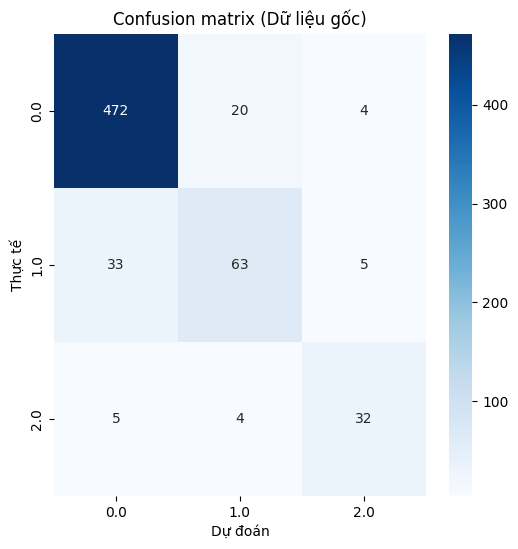

In [886]:
conf_matrix_best = confusion_matrix(y_test_best, y_pred_best)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion matrix (Dữ liệu gốc)")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()


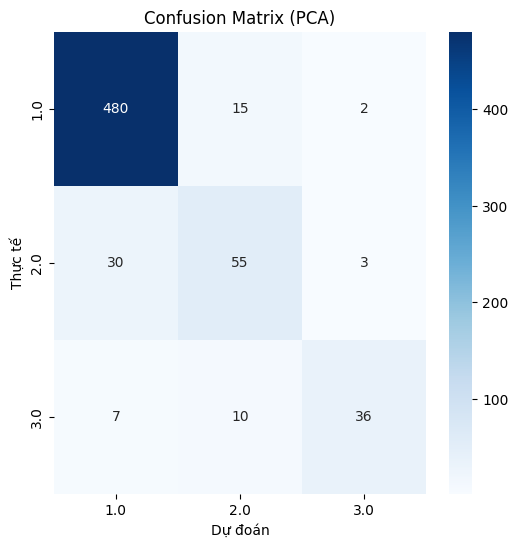

In [882]:
conf_matrix_pca = confusion_matrix(y_test_pca, y_pred_pca)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_pca, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (PCA)")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

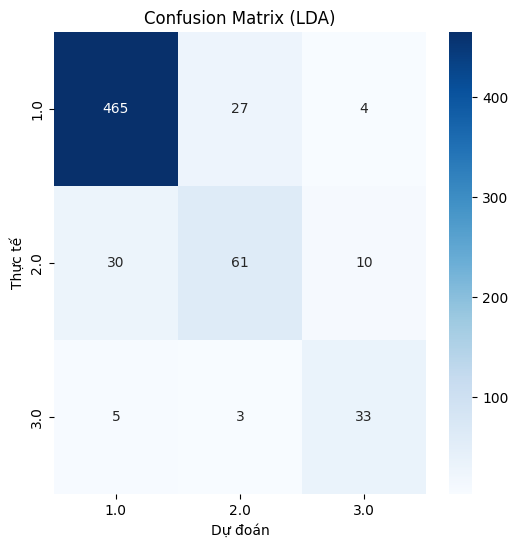

In [883]:
conf_matrix_lda = confusion_matrix(y_test_lda, y_pred_lda)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_lda, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (LDA)")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()
